# Capstone Project - The Battle of the Neighborhoods (Final)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Background:** Pune is one of the fastest growing cities of India. The city has seen a major growth in population as it is moving ahead in its path of being a hub for IT and Education services. It is also in the process of becoming a SMART city attracting even more people.
The property costs in Pune are not as high as other major cities of India. But with good average income, this city is a good candidate for business. Specially Restaurant business as the city has people from all over India as well as people from outside India residing in the city working for the IT companies. It seems to be a good time to open a milti-cuisine or franchise (McD, KFC etc) restaurant in the growing city of Pune.

**Problem:** Best location to open a new restaurant in Pune. The success of a restaurant is affected by its **location, area population and other attractions in the area.** Hence, it is very impertant to do a thorough analysis of the optimal location for opening the new restarant.

**Audience:** A person looking to open a new restaurant in the city.

**Solution Approach:**
In this project we will try to find an **optimal location for a restaurant in the city of Pune India**. 

Using data analysis techniques we will find out the density of restaurants in various neighborhoods of the city. 
We will also find the top venues of the area. 

Then we will find areas with low density of restaurants and some new attractions comming in like a big IT firm opening their office or a new multiplex being constructed in the area etc.

## Data <a name="data"></a>

For the problem discussed above, I have taken below data for the city of Pune, India:
    - Neighborhoods
    - Map coordinates of the neighborhoods
    - Various types of venues in 500m of the neighborhoods
    - Current attraction  - a new/undergoing project 

**Sources**:
    - Neighborhoods data is taken from Wikipedia
    - Coordinates are taken using Google Maps API geocoders
    - Venues data is taken from Foursquare API

Further I will be using google to check for news of any new/ongoing projects, IT offices, multiplexes being constructed in the areas of choice we get. So that we are able to make an even better suggestion.


**For Example -**
Lets say after our analisys, we get two neighborhoods n1 and n2 that seems like optimal optins for opening a restaurant.
Then using the additional data, we can if there is a new/ongoing IT SEZ office with a capacity of 10,000 people is being/just constructed in (say) n1. On the other hand there are no such activities going on in n2. According to this, we will be able to recommend n1 over n2.

The dataset created contains information about the venues (from Foursquare.com) under 64 unique venue categories for all neighborhoods in the city.

I will analyse the data further on below points:
- number of venue in restaurands/food category in the neighborhoods
- neighborhoods with nearby venues like IT Center, Malls, Multiplexes or Cineplex, Education centers will be given preference in selection
- neighborhoods with high rate of housing sales will be further given preference

Use [link](#datafinal) to checkout the master dataset.

**== !Importing libraries! ==**

In [2]:
import pandas as pd
import numpy as np
import requests
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.pyplot as plt

**====!Loading Neighborhoods in dataframe!====**

In [5]:
df=pd.read_csv(r'C:\Users\user\Desktop\Coursera_Assignment\Project\Project\Pune_Neighborhoods.csv',encoding= 'unicode_escape')
df=df.fillna(0)
df.head()

,Neighborhood,Latitude,Longitude
0,Aundh,0.0,0.0
1,Baner,0.0,0.0
2,Bavdhan Khurd,0.0,0.0
3,Bavdhan Budruk,0.0,0.0
4,Balewadi,0.0,0.0


**Creating google geocoder locater instance**

In [6]:
locator = Nominatim(user_agent='myGeocoder')

**Fetching coordinates for all neighborhoods in the dataframe**

In [7]:
for x in range(len(df)):
    location = locator.geocode(f'{df.iloc[x,0]}, Pune, India')
    df.iloc[x,1]=location.latitude
    df.iloc[x,2]=location.longitude

In [8]:
df.head()

,Neighborhood,Latitude,Longitude
0,Aundh,18.561883,73.810196
1,Baner,18.564243,73.776857
2,Bavdhan Khurd,18.313881,74.023109
3,Bavdhan Budruk,18.529135,73.778700
4,Balewadi,18.582027,73.768983


### Let's use folium to create map of Pune city

In [9]:
# create map using latitude and longitude values
location = locator.geocode('Pune, India')
latitude=location.latitude
longitude=location.longitude
neighborhoods=df

map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{} , Pune, India'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

### Lets try to fetch the venues nearby all the neighborhoods in the city

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Let's create a function to clean the json returned from Foursquare api and structure it into a pandas dataframe for all the neighborhoods in Pune India

Provide Foursquare credentials for making a connection for API calls

In [11]:
CLIENT_ID = 'D1IXAYF5EGVSEDQ2PFFO01KVVXCYAICFE0F5YXMDPX1Z4STE' # your Foursquare ID
CLIENT_SECRET = 'WMFCF5KXW4N5PH0Q0J4NEZHE134H441NKFZFEGD4I1YJ2Z2H' # your Foursquare Secret
VERSION = '20200306'
LIMIT = 30

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now write the code to run the above function on each neighborhood and create a new dataframe called york_venues.

In [15]:
neigh_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Aundh
Baner
Bavdhan Khurd
Bavdhan Budruk
Balewadi
Shivajinagar
Bibvewadi
Bhugaon
Bhukum
Dhanori
Ghorpadi
Hadapsar
Hinjewadi
Katraj
Khadki
Kharadi
Kondhwa
Koregaon Park
Kothrud
Mundhwa
Nanded
Pashan
Pirangut
Sus
Vishrantwadi
Wadgaon Sheri
Wagholi
Warje
Yerwada


Let's check the newly created dataframe

In [16]:
neigh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aundh,18.561883,73.810196,Westend mall,18.561814,73.807220,Shopping Mall
1,Aundh,18.561883,73.810196,Cinepolis IMAX,18.561756,73.807192,Multiplex
2,Aundh,18.561883,73.810196,Picantos Mexican Grill,18.560654,73.812447,Mexican Restaurant
3,Aundh,18.561883,73.810196,Venkys Xprs,18.560550,73.808964,Fast Food Restaurant
4,Aundh,18.561883,73.810196,Café Maroo,18.564801,73.809141,Korean Restaurant


In [17]:
neigh_venues.shape

(167, 7)

In [18]:
neigh_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aundh,30,30,30,30,30,30
Baner,12,12,12,12,12,12
Bavdhan Budruk,3,3,3,3,3,3
Bhugaon,4,4,4,4,4,4
Bhukum,1,1,1,1,1,1
Bibvewadi,5,5,5,5,5,5
Dhanori,1,1,1,1,1,1
Ghorpadi,4,4,4,4,4,4
Hadapsar,1,1,1,1,1,1


### Lets map this data to find 5 areas with most and least venues count 

In [20]:
neigh_grouped=neigh_venues.groupby('Neighborhood').count()
neigh_grouped.reset_index(inplace=True)

In [21]:
neigh_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aundh,30,30,30,30,30,30
1,Baner,12,12,12,12,12,12
2,Bavdhan Budruk,3,3,3,3,3,3
3,Bhugaon,4,4,4,4,4,4
4,Bhukum,1,1,1,1,1,1


In [22]:
# Lets sort the values by venue counts
neigh_grouped.sort_values(by='Venue',inplace=True)

Making a bar chart for the five areas with most number of venues

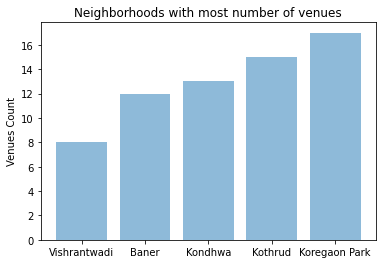

In [23]:
plt.bar(neigh_grouped['Neighborhood'][-6:-1],neigh_grouped['Venue'][-6:-1], align='center', alpha=0.5)
plt.ylabel('Venues Count')
plt.title('Neighborhoods with most number of venues')

plt.show()

Making a bar chart for the five areas with least number of venues

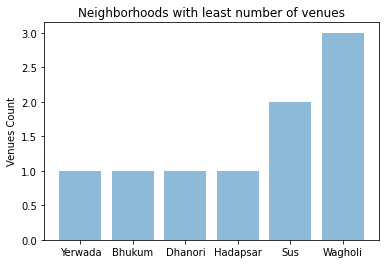

In [24]:
plt.bar(neigh_grouped['Neighborhood'][0:6],neigh_grouped['Venue'][0:6], align='center', alpha=0.5)
plt.ylabel('Venues Count')
plt.title('Neighborhoods with least number of venues')

plt.show()

### Let's check the unique categories retruned for the city

In [25]:
print('There are {} uniques categories.'.format(len(neigh_venues['Venue Category'].unique())))

There are 68 uniques categories.


## Finally the data looks like below now <a name="datafinal"></a>

In [26]:
neigh_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aundh,18.561883,73.810196,Westend mall,18.561814,73.807220,Shopping Mall
1,Aundh,18.561883,73.810196,Cinepolis IMAX,18.561756,73.807192,Multiplex
2,Aundh,18.561883,73.810196,Picantos Mexican Grill,18.560654,73.812447,Mexican Restaurant
3,Aundh,18.561883,73.810196,Venkys Xprs,18.560550,73.808964,Fast Food Restaurant
4,Aundh,18.561883,73.810196,Café Maroo,18.564801,73.809141,Korean Restaurant
...,...,...,...,...,...,...,...
162,Wagholi,18.580630,73.983310,Smokin Joes,18.581895,73.987545,Pizza Place
163,Warje,18.482044,73.800170,Amrpali Bar And Restaurant,18.484177,73.800002,Bar
164,Warje,18.482044,73.800170,More,18.485132,73.799398,Grocery Store
165,Warje,18.482044,73.800170,Mystic Flavours,18.485079,73.798939,Indian Restaurant


## Methodology <a name="methodology"></a>

Using the above data, we will try to find the area in the city which will be optimal for opening a restaurant. This area is expected to have fewer number of restaurants as compared to other areas.

Another factor to keep check of is the location of the area in the city. A restaurant closer to cities center has higher chances of success than an area in the outskirts.

To prepare the data, we will take all neighborhoods and their coordinates using Foursquare API.

Further we will take trending venues in the neighborhoods within a radius of 0.5 km. We will categorise the neighborhoods with the venue density to get an idea of the neighborhoods with most and least number of Restaurants.

Then we will take the top 10 most common venues for each neighborhood. Next we will merge it with location coordinates. Then using this data we will create clusters using k-means clustering and will plot the clusters on a map using folium.

Finally we will recognize the neighborhoods with low density of restaurants and further add the Property Rates of the neighborhoods. To find for a good solution, we will identify the area with optimal venue density and Property Rate. As both these are factors in selecting an area for a new restaurant.


## Analysis <a name="analysis"></a>

### Let's perform some basic explanatory data analysis and derive some additional info from our raw data. 
First let's find every venue in the neighborhood:

In [27]:
# one hot encoding

neigh_onehot = pd.get_dummies(neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neigh_onehot['Neighborhood'] = neigh_venues['Neighborhood'] 

#move neighborhood column to the first column
fixed_columns = [neigh_onehot.columns[-1]] + (neigh_onehot.columns[:-1]).values.tolist()
neigh_onehot = neigh_onehot[fixed_columns]

neigh_onehot.head()


,Neighborhood,ATM,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Breakfast Spot,Bus Line,...,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Sporting Goods Shop,Tea Room,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Zoo
0,Aundh,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Aundh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aundh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aundh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aundh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
neigh_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
neigh_grouped.head()

,Neighborhood,ATM,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Breakfast Spot,Bus Line,...,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Sporting Goods Shop,Tea Room,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Zoo
0,Aundh,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.033333,0.033333,...,0.0,0.066667,0.033333,0.0,0.066667,0.0,0.0,0.0,0.033333,0.0
1,Baner,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Bavdhan Budruk,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Bhugaon,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,Bhukum,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### Let's write a function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [30]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = york_grouped['Neighborhood']

for ind in np.arange(york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neigh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aundh,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Clothing Store,Sporting Goods Shop,Shopping Mall,Vegetarian / Vegan Restaurant,Jewelry Store,Juice Bar,Kids Store
1,Baner,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Motorcycle Shop,Grocery Store,Gourmet Shop,Café,Seafood Restaurant,Flea Market,Exhibit
2,Bavdhan Budruk,Lake,Indian Restaurant,Fast Food Restaurant,Gourmet Shop,Exhibit,Farmers Market,Flea Market,Food,Fruit & Vegetable Store,Zoo
3,Bhugaon,ATM,Seafood Restaurant,Lake,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Fruit & Vegetable Store
4,Bhukum,ATM,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Gourmet Shop,Vegetarian / Vegan Restaurant
5,Bibvewadi,Ice Cream Shop,Seafood Restaurant,Gym,Bakery,Café,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food
6,Dhanori,Restaurant,Zoo,Food,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Fruit & Vegetable Store,Dessert Shop
7,Ghorpadi,Park,Train Station,Art Gallery,Gym,Food,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market
8,Hadapsar,Train Station,Zoo,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Gourmet Shop
9,Hinjewadi,Other Nightlife,Indian Restaurant,Tea Room,Athletics & Sports,Breakfast Spot,Bus Station,Road,Restaurant,Food,Eastern European Restaurant


### Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [32]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

neigh_grouped_clustering = neigh_grouped.drop('Neighborhood', 1)

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(york_grouped_clustering)
kmeans = KMeans(init="k-means++",n_clusters=kclusters, random_state=0,n_init=12).fit(neigh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 3, 3, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neigh_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#york_merged = york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#york_merged = york_merged.join(neighborhoods_venues_sorted, on='Neighborhood')
neigh_merged=pd.merge(neigh_merged, neighborhoods_venues_sorted, how='inner', on='Neighborhood')


In [34]:
neigh_merged.shape

(26, 14)

In [35]:
neigh_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aundh,18.561883,73.810196,0,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Clothing Store,Sporting Goods Shop,Shopping Mall,Vegetarian / Vegan Restaurant,Jewelry Store,Juice Bar,Kids Store
1,Baner,18.564243,73.776857,0,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Motorcycle Shop,Grocery Store,Gourmet Shop,Café,Seafood Restaurant,Flea Market,Exhibit
2,Bavdhan Budruk,18.529135,73.778700,0,Lake,Indian Restaurant,Fast Food Restaurant,Gourmet Shop,Exhibit,Farmers Market,Flea Market,Food,Fruit & Vegetable Store,Zoo
3,Shivajinagar,18.532591,73.851311,0,Department Store,Restaurant,Indian Restaurant,Hospital,Hotel,BBQ Joint,Bakery,Art Gallery,Asian Restaurant,Hookah Bar
4,Bibvewadi,18.478174,73.862105,0,Ice Cream Shop,Seafood Restaurant,Gym,Bakery,Café,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food


## Finally, let's visualize the resulting clusters

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigh_merged['Latitude'], neigh_merged['Longitude'], neigh_merged['Neighborhood'], neigh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysing 1st Cluster

In [37]:
neigh_merged.loc[neigh_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aundh,18.561883,73.810196,0,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Clothing Store,Sporting Goods Shop,Shopping Mall,Vegetarian / Vegan Restaurant,Jewelry Store,Juice Bar,Kids Store
1,Baner,18.564243,73.776857,0,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Motorcycle Shop,Grocery Store,Gourmet Shop,Café,Seafood Restaurant,Flea Market,Exhibit
2,Bavdhan Budruk,18.529135,73.778700,0,Lake,Indian Restaurant,Fast Food Restaurant,Gourmet Shop,Exhibit,Farmers Market,Flea Market,Food,Fruit & Vegetable Store,Zoo
3,Shivajinagar,18.532591,73.851311,0,Department Store,Restaurant,Indian Restaurant,Hospital,Hotel,BBQ Joint,Bakery,Art Gallery,Asian Restaurant,Hookah Bar
4,Bibvewadi,18.478174,73.862105,0,Ice Cream Shop,Seafood Restaurant,Gym,Bakery,Café,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food
8,Ghorpadi,18.526854,73.900096,0,Park,Train Station,Art Gallery,Gym,Food,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market
10,Hinjewadi,18.592094,73.757142,0,Other Nightlife,Indian Restaurant,Tea Room,Athletics & Sports,Breakfast Spot,Bus Station,Road,Restaurant,Food,Eastern European Restaurant
11,Katraj,18.453679,73.856320,0,Zoo,Bus Station,Food,Exhibit,Dessert Shop,Indian Restaurant,Asian Restaurant,Hotel,Hospital,Hookah Bar
12,Khadki,18.568175,73.850779,0,Department Store,Tea Room,Bakery,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food
13,Kharadi,18.550518,73.942494,0,Indian Restaurant,Tea Room,Fast Food Restaurant,Zoo,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Flea Market,Food


### Analysing 2nd Cluster

In [38]:
neigh_merged.loc[neigh_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Hadapsar,18.526967,73.927825,1,Train Station,Zoo,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Gourmet Shop


### Analysing 3rd Cluster

In [39]:
neigh_merged.loc[neigh_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Yerwada,18.550361,73.879746,2,Donut Shop,Fruit & Vegetable Store,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Food,Zoo,Vegetarian / Vegan Restaurant


### Analysing 4th Cluster

In [40]:
neigh_merged.loc[neigh_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Dhanori,18.590671,73.891319,4,Restaurant,Zoo,Food,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Flea Market,Fruit & Vegetable Store,Dessert Shop
23,Wagholi,18.580630,73.983310,4,Indian Restaurant,Pizza Place,Restaurant,Zoo,Flea Market,Eastern European Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Food


### From above it can be seen that we are able to select some neighborhoods that look potential optimal options. Like Hadapsar, Yerwada, Dhanori and Wagholi. Lets analyse further!

In [41]:
#lets get dataframe of only these neighborhoods
options=['Yerwada' , 'Wagholi' ,'Hadapsar' , 'Dhanori']
dfn=pd.DataFrame(columns=neigh_merged.columns)
i=0
for n in range(len(neigh_merged)):
    for x in options:
        if neigh_merged.iloc[n,0] == x:
            #print(york_merged.iloc[n,0])
            dfn=dfn.append(neigh_merged.iloc[n,:])

#Lets just keep the top 3 venues
dfn=dfn.iloc[:,0:7]
dfn.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,Dhanori,18.590671,73.891319,4,Restaurant,Zoo,Food
9,Hadapsar,18.526967,73.927825,1,Train Station,Zoo,Fruit & Vegetable Store
23,Wagholi,18.580630,73.983310,4,Indian Restaurant,Pizza Place,Restaurant
25,Yerwada,18.550361,73.879746,2,Donut Shop,Fruit & Vegetable Store,Eastern European Restaurant


In [42]:
#Lets brings in Property Rates 
dfp=pd.read_csv(r'C:\Users\user\Desktop\Coursera_Assignment\Project\Project\Pune_Property_Rates.csv',encoding= 'unicode_escape')
dfp.head()

,Neighborhood,Property_Rates
0,Abasaheb Raikar Nagar,3952
1,Akurdi,5355
2,Alandi,3315
3,Alandi Road,3868
4,Ambegaon,4335


In [43]:
# Now lets merge the two dataframes
optimal_options=dfn.merge(dfp,on='Neighborhood', how='left')

In [44]:
optimal_options['Distance from center of City']=0
optimal_options

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Property_Rates,Distance from center of City
0,Dhanori,18.590671,73.891319,4,Restaurant,Zoo,Food,4632,0
1,Hadapsar,18.526967,73.927825,1,Train Station,Zoo,Fruit & Vegetable Store,5100,0
2,Wagholi,18.580630,73.983310,4,Indian Restaurant,Pizza Place,Restaurant,3782,0
3,Yerwada,18.550361,73.879746,2,Donut Shop,Fruit & Vegetable Store,Eastern European Restaurant,6758,0


In [45]:
import math  

x2=18.521428 #pune latitude
y2=73.8544541 #pune longitude
for x in range(len(optimal_options)):
    x1=optimal_options.iloc[x,1]
    y1=optimal_options.iloc[x,2]
    optimal_options.iloc[x,-1] = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)


In [46]:
optimal_options

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Property_Rates,Distance from center of City
0,Dhanori,18.590671,73.891319,4,Restaurant,Zoo,Food,4632,0.078445
1,Hadapsar,18.526967,73.927825,1,Train Station,Zoo,Fruit & Vegetable Store,5100,0.073580
2,Wagholi,18.580630,73.983310,4,Indian Restaurant,Pizza Place,Restaurant,3782,0.141805
3,Yerwada,18.550361,73.879746,2,Donut Shop,Fruit & Vegetable Store,Eastern European Restaurant,6758,0.038429


## Results & Discussion <a name="results"></a>

Our analysis shows that above are the areas with low density of venues as compared to other areas of the city. Interesting to note that three of these areas are not very far from the city center. 

On further analysing these areas on factors like popualtion density, and other major attaractions in the area, we see that the area **'Yerwada'** contains a lot of Business Parks, big Hotels, golf corse ground and more. Even though property rates are a nit high but this area also has least distance from city center. Which looks like a good trade off. 

Another location that looks promising is **'Hadapsar'** where on further analysis we found that a lot of new construction is going on in this area. And it is nearby to international airport.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify an optimal location to open a new retaurant in the city of Pune India. 

The above data has been created using the neighborhoods of the city, the coordinates and the various venues density in the neighborhoods.
Using the method of clustering, the above locations were divided in to clusters depending on most famous venues in the areas.
As expected the old and highly developed/expecsive parts of the city were found part of one cluster. That proved the accuracy of the measures. Above areas listed as optimal options were not part of such clusters, hence good candidates for the problems solution. 

The results can help an interested audience to take an informed decision. As there is no limitation to data, more factors can be taken into account along with above information to finalize a location. Details like new/ongoing projects, Business Parks or Cineplexes in the area, connectivity of metro lines to the area, population of the area etc are few factors that can add value to take a decision.


### Data References:
- Google geocoder API
- Foursquare API
- https://www.99acres.com/property-rates-and-price-trends-in-pune
- https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Pune